# Visualizing Features Extracted using make_feature_pipeline and make_oversample_feature_pipeline (BINARY CLASS)

In [1]:
from hasp.feature_pipeline import make_feature_pipeline as mfp
from hasp.feature_pipeline import make_oversampled_feature_pipeline as mofp
from hasp.augmenting_oversampler import AugmentingRandomOversampler as OverSampler
from sklearn.manifold import TSNE
from hasp.util import combine_classes
from xgboost import XGBClassifier
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Data

In [2]:
from us8kdata.loader import UrbanSound8K
data = UrbanSound8K('../hasp/data')

In [3]:
train_fold = [samples for samples in data.fold_audio_generator(fold=[1, 2, 3, 6, 7, 8, 9, 10])]
train_y = data.filter_metadata(fold=[1, 2, 3, 6, 7, 8, 9, 10]).classID

In [4]:
target_classes = [1, 3, 8]
com_train_y = combine_classes(target_classes, train_y, binary=True)

# Pipe (make_feature_pipeline w/o delta)

In [5]:
pipe2 = mfp()
pipe2.set_params(mean_mfcc__kw_args={'sr': 16000, 
                                    'n_mfcc': 16, 
                                    'n_fft':256, 
                                    'hop_length': 128,
                                    'fmin': 0.0, 
                                    'fmax': 3000.0,
                                    'n_mels': 100, 
                                    'delta1':False,
                                    'delta2':False
                                    })

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': False, 'delta2': False,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mels': 100, 'n_mfcc': 16,
                                              'sr': 16000})),
                ('scaler', StandardScaler())])

In [6]:
x2 = pipe2.fit_transform(train_fold, com_train_y)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual -Features

In [73]:
x2_embedded = TSNE(n_components=2, init='random', 
                 perplexity=1000, learning_rate='auto').fit_transform(x2)

Text(0, 0.5, 'Dimension 2')

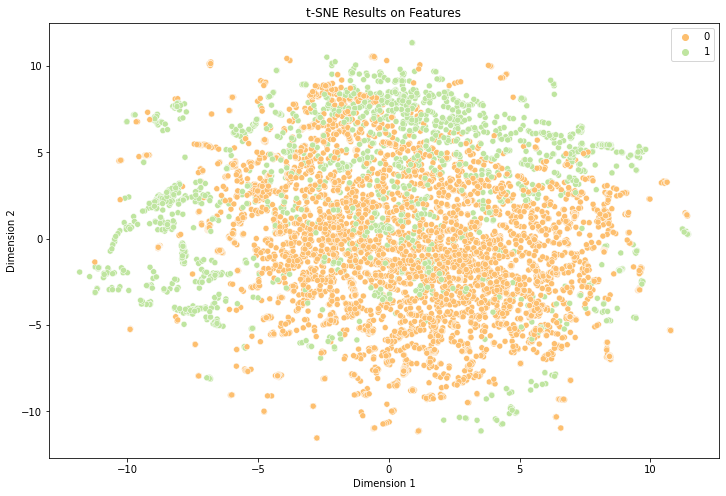

In [74]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x2_embedded[:, 0], 
                    y=x2_embedded[:, 1], 
                    hue=com_train_y, 
                    palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Pipe (make_oversampled_feature_pipeline w/o delta, AddGaussianNoise)

In [9]:
pipe3 = mofp()
pipe3.set_params(
**{'estimator':XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {'sr': 16000,'n_mfcc': 16,
  'n_fft': 256,'hop_length': 128,
  'fmin': 0.0, 'fmax': 3000.0, 'n_mels': 100, 
  'delta1':True,'delta2':False},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')} 
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14723d670>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': True, 'delta2': False,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [10]:
x3, y3 = pipe3[:2].fit_resample(train_fold, com_train_y)

In [11]:
new_x3 = pipe3[2:-1].fit_transform(x3)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual -Features

In [75]:
x3_embedded = TSNE(n_components=2, learning_rate='auto', 
                  init='random', perplexity=1000).fit_transform(new_x3)

Text(0, 0.5, 'Dimension 2')

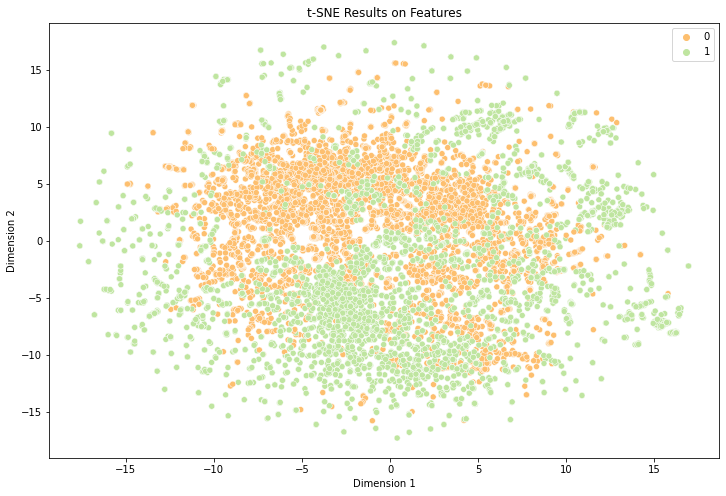

In [76]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x3_embedded[:, 0],
                      y=x3_embedded[:, 1],
                     hue=y3, 
                     palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Pipe (make_feature_pipeline, delta1)

In [14]:
pipe4 = mfp()
pipe4.set_params(mean_mfcc__kw_args={'sr': 16000, 
                                    'n_mfcc': 16, 
                                    'n_fft':256, 
                                    'hop_length': 128,
                                    'fmin': 0.0, 
                                    'fmax': 3000.0,
                                    'n_mels': 100, 
                                    'delta1':True,
                                    'delta2':False
                                    })

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': True, 'delta2': False,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mels': 100, 'n_mfcc': 16,
                                              'sr': 16000})),
                ('scaler', StandardScaler())])

In [15]:
x4 = pipe4.fit_transform(train_fold, com_train_y)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual -Features

In [77]:
x4_embedded = TSNE(n_components=2, perplexity=1000, 
                  init='random', learning_rate='auto').fit_transform(x4)

Text(0, 0.5, 'Dimension 2')

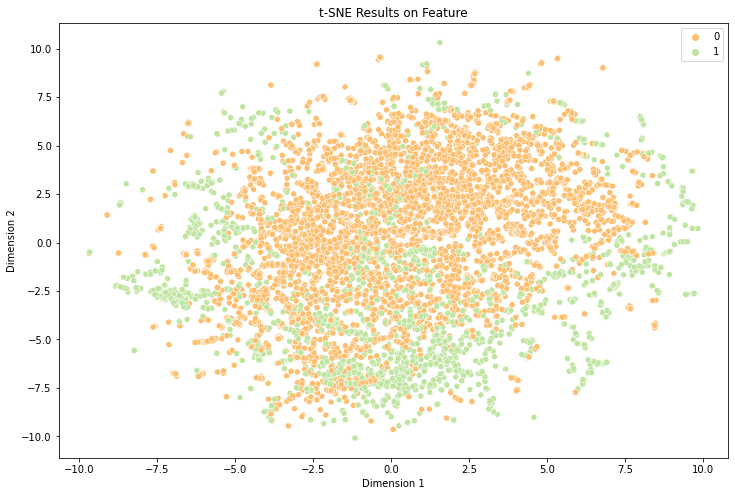

In [78]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x4_embedded[:, 0],
                    y=x4_embedded[:, 1], 
                    hue=com_train_y,
                    palette='Spectral')

plt.title('t-SNE Results on Feature')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Pipe (make_oversample_feature_pipeline, delta1, AddGaussionNoise)

In [18]:
pipe5 = mofp()
pipe5.set_params(
**{'estimator':XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {'sr': 16000,'n_mfcc': 16,
  'n_fft': 256,'hop_length': 128,
  'fmin': 0.0, 'fmax': 3000.0, 'n_mels': 100, 
  'delta1':True,'delta2':False},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')} 
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14723d670>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': True, 'delta2': False,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [19]:
x5, y5 = pipe5[:2].fit_resample(train_fold, com_train_y)

In [20]:
new_x5 = pipe5[2:-1].fit_transform(x5)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual -Features

In [79]:
x5_embedded = TSNE(n_components=2, perplexity=1000, 
                  init='random', learning_rate='auto').fit_transform(new_x5)

Text(0, 0.5, 'Dimension 2')

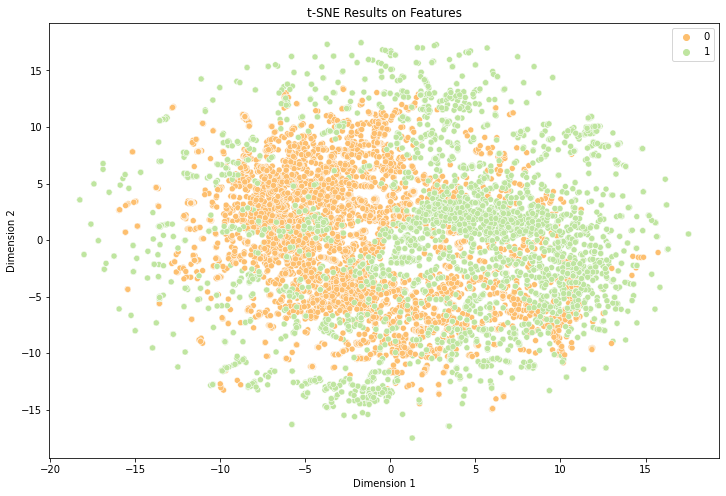

In [80]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x5_embedded[:, 0], 
                    y=x5_embedded[:, 1], 
                    hue=y5, 
                    palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Pipe (make_feature_pipeline, delta2) 

In [23]:
pipe6 = mfp()
pipe6.set_params(mean_mfcc__kw_args={'sr': 16000, 
                                    'n_mfcc': 16, 
                                    'n_fft':256, 
                                    'hop_length': 128,
                                    'fmin': 0.0, 
                                    'fmax': 3000.0,
                                    'n_mels': 100, 
                                    'delta1':False,
                                    'delta2':True})

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': False, 'delta2': True,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mels': 100, 'n_mfcc': 16,
                                              'sr': 16000})),
                ('scaler', StandardScaler())])

In [24]:
x6 = pipe6.fit_transform(train_fold, com_train_y)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual 

In [81]:
x6_embedded = TSNE(n_components=2, perplexity=1000, 
                  init='random', learning_rate='auto').fit_transform(x6)

Text(0, 0.5, 'Dimension 2')

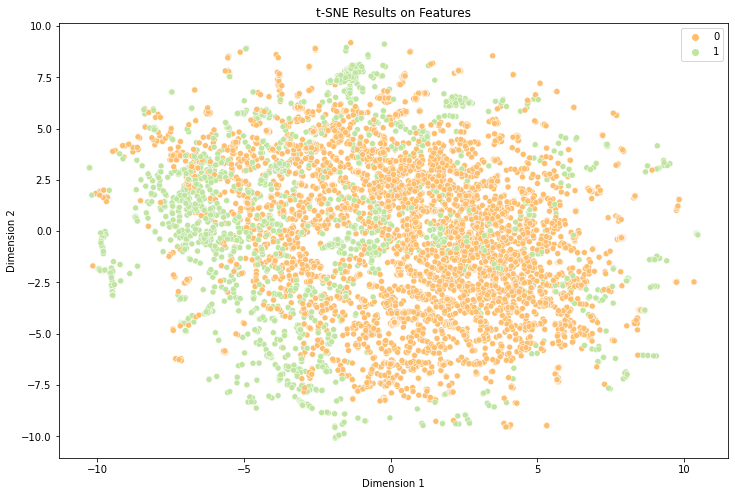

In [82]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x6_embedded[:, 0], 
                    y=x6_embedded[:, 1], 
                    hue=com_train_y,
                    palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Pipe (make_oversample_feature_pipeline, delta2, AddGaussianNoise)

In [27]:
pipe7 = mofp()
pipe7.set_params(
**{'estimator':XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {'sr': 16000,'n_mfcc': 16,
  'n_fft': 256,'hop_length': 128,
  'fmin': 0.0, 'fmax': 3000.0, 'n_mels': 100, 
  'delta1':False,'delta2':True},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')})

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14723d670>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': False, 'delta2': True,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [28]:
x7, y7 = pipe7[:2].fit_resample(train_fold, com_train_y)

In [29]:
new_x7 = pipe7[2:-1].fit_transform(x7)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual -Features

In [83]:
x7_embedded = TSNE(n_components=2, perplexity=1000, 
                  init='random', learning_rate='auto').fit_transform(new_x7)

Text(0, 0.5, 'Dimension 2')

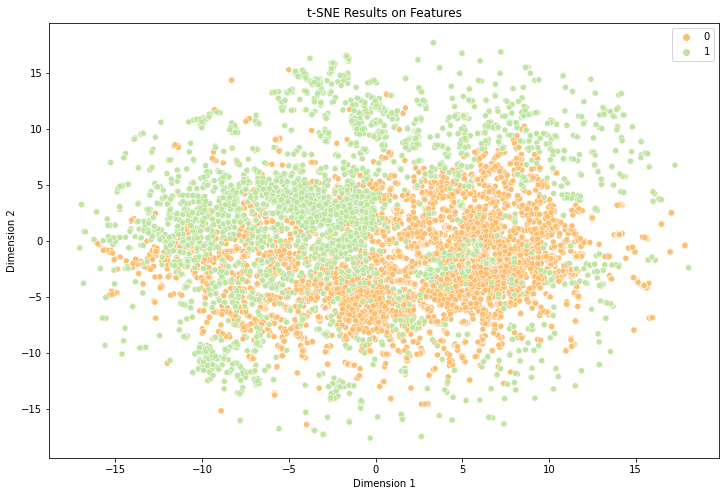

In [84]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x7_embedded[:, 0], 
                    y=x7_embedded[:, 1],
                    hue=y7,
                    palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Pipe (make_feature_pipeline, 2 deltas)

In [40]:
pipe8 = mfp()
pipe8.set_params(mean_mfcc__kw_args={'sr': 16000, 
                                    'n_mfcc': 16, 
                                    'n_fft':256, 
                                    'hop_length': 128,
                                    'fmin': 0.0, 
                                    'fmax': 3000.0,
                                    'n_mels': 100, 
                                    'delta1':True,
                                    'delta2':True
                                    })

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': True, 'delta2': True,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mels': 100, 'n_mfcc': 16,
                                              'sr': 16000})),
                ('scaler', StandardScaler())])

In [41]:
x8 = pipe8.fit_transform(train_fold, com_train_y)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual -Features

In [85]:
x8_embedded = TSNE(n_components=2, perplexity=1000, 
                  init='random', learning_rate='auto').fit_transform(x8)

Text(0, 0.5, 'Dimension 2')

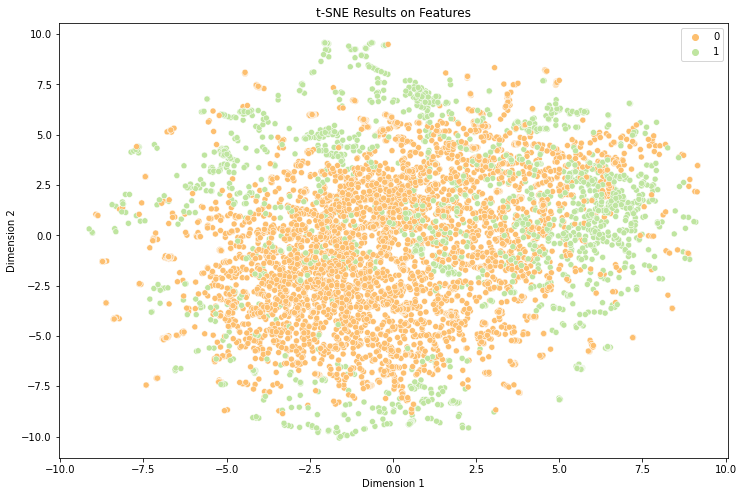

In [86]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x8_embedded[:, 0], 
                    y=x8_embedded[:, 1], 
                    hue=com_train_y, 
                    palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Pipe (make_oversampled_feature_pipeline, 2 deltas, AddGaussianNoise)

In [45]:
pipe9 = mofp()
pipe9.set_params(
**{'estimator':XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {'sr': 16000,'n_mfcc': 16,
  'n_fft': 256,'hop_length': 128,
  'fmin': 0.0, 'fmax': 3000.0, 'n_mels': 100, 
  'delta1':True,'delta2':True},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')}
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14723d670>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10ee93d30>,
                                     kw_args={'delta1': True, 'delta2': True,
                                              'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128,...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [47]:
x9, y9 = pipe9[:2].fit_resample(train_fold, com_train_y)

In [48]:
new_x9 = pipe9[2:-1].fit_transform(x9)

/Users/carlquin/.pyenv/versions/3.8.13/envs/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Visual -Features

In [71]:
x9_embedded = TSNE(n_components=2, perplexity=1000,
                  init='random', learning_rate='auto').fit_transform(new_x9)

Text(0, 0.5, 'Dimension 2')

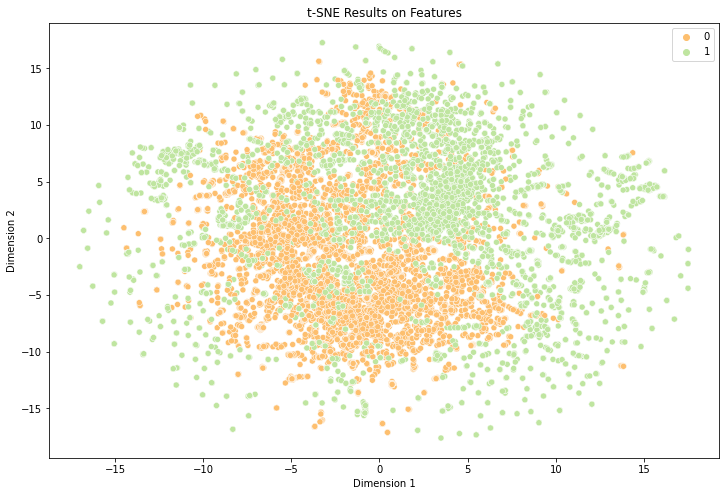

In [72]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x9_embedded[:, 0],
                    y=x9_embedded[:, 1],
                    hue=y9,
                    palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Conclusion

Larger datasets normally require higher perplexity.

Cells are rerun a several times starting on perplexity=12 to 1000, an increase in the number of points is observed.

However, the distribution does not distinctively differs as perplexity increases. 